In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import scipy as sp
import matplotlib.pyplot as plt
import re
from os import listdir
from os.path import isfile, join
from scipy import stats

from sklearn import preprocessing

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier

from sklearn.ensemble import VotingClassifier

# Evaluation Procedures
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import precision_recall_curve 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

In [2]:
rare_AD = pd.read_csv('../Data/data_gc_poly_unique_1319.csv')

In [3]:
pheno = pd.read_csv('../Data/phenotypes_1319.csv',sep=';')

Scarto le mutazioni che terminano con `_0` e gli `artefatti`

In [4]:
todrop = rare_AD.columns[rare_AD.columns.str.contains('_0')].tolist()
todrop += ['ARSD_1', 'ARSD_0', 'VCX_1','VCX2_1', 'VCX2_2']
rare_AD.drop(columns=todrop, inplace=True)

Rimuovo i geni del cromosoma X

In [5]:
chr_X = pd.read_csv('../Data/Male/genes_chrX.csv')
genes_X = np.intersect1d(chr_X['genes_x'].tolist(), rare_AD.columns.tolist())
genes_X = chr_X['genes_x'].tolist()

In [6]:
selected = []
for x in rare_AD.columns:
    gene = x.split('_')[0]
    if gene in chr_X['genes_x'].tolist():
        selected.append(x)

In [7]:
rare_AD.drop(columns=selected, inplace=True)

Filtro per etnia

In [8]:
pheno.rename(columns={'diabetes (1=affected, 0=not affected, N/A= data not available)':'Diabetes',
                     'hypertension (1=affected, 0=not affected, N/A= data not available)':'Hypertension',
                     'cancer  (1=affected, 0=not affected, N/A= data not available)':'Cancer',
                     'Autoimmune disease (1 = Yes, 0 = No)':'Autoimmune disease',
                     'Congestive/Ischemic Heart Failure (1= Yes; 0=No)':'Congestive/Ischemic Heart Failure',
                     'Obesity (1= Yes; 0=No)':'Obesity',
                     'Dyslipidemia (1= Yes; 0=No)':'Dyslipidemia',
                     'Hypothyroidism (1= Yes; 0=No)':'Hypothyroidism',
                     'Asthma/COPD/OSAS (1= Yes; 0=No)':'Asthma/COPD/OSAS'}, inplace=True)

Mantengo solo pazienti con un grading

In [9]:
pheno = pheno[pheno['grading_1319_adj_a_s'].notna()]

Scarto pazienti senza età

In [10]:
pheno = pheno[pheno['Age'].notna()]

Cambio l'indice dei pazienti

In [11]:
pheno.rename(columns={"UsedSampleCode":"key"}, inplace=True)
pheno.set_index('key',inplace=True)

Scarto pazienti non corrispondenti (?)

In [12]:
rare_AD.rename(columns={"Unnamed: 0": "key"}, inplace=True)
rare_AD.set_index('key',inplace=True)

rare_AD = rare_AD[rare_AD.index != 'COV2925-1241_hg38']
rare_AD = rare_AD[rare_AD.index != 'COV2928-1242_hg38']
rare_AD = rare_AD[rare_AD.index != 'COV3204-1334_hg38']
rare_AD = rare_AD[rare_AD.index != 'COV3196-1326_hg38']
rare_AD = rare_AD[rare_AD.index != 'COV2735-1159_hg38']
rare_AD = rare_AD[rare_AD.index != 'COV3211-1341_hg38']
rare_AD = rare_AD[rare_AD.index != 'COV2233-939_hg38']

rare_AD.index = rare_AD.index.str.replace('_hg38','')

In [13]:
len(pheno)

1312

In [34]:
grading = pheno[['grading_1319_adj_a_s','Diabetes', 'Hypertension',
                 'Cancer', 'Autoimmune disease','Congestive/Ischemic Heart Failure', 
                 'Asthma/COPD/OSAS',
       'Hypothyroidism', 'Obesity', 'Dyslipidemia','Gender (M=0, F=1)']]

df = rare_AD.join(grading, on='key')
df.rename(columns={'grading_1319_adj_a_s':'grading'}, inplace=True)

df

,AADACL3_1,ABCA4_1,ABCA4_2,ABCA4_3,ABL2_1,ACBD3_1,ACKR1_1,ACKR1_2,ACTL8_1,ACTN2_1,...,Diabetes,Hypertension,Cancer,Autoimmune disease,Congestive/Ischemic Heart Failure,Asthma/COPD/OSAS,Hypothyroidism,Obesity,Dyslipidemia,"Gender (M=0, F=1)"
key,,,,,,,,,,,,,,,,,,,,,
AR-COV-10,0,1,0,0,0,0,1,0,1,1,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0
AR-COV-11,0,0,0,0,0,1,1,0,1,1,...,1.0,0.0,0.0,1.0,0,0.0,0.0,0.0,0.0,1.0
AR-COV-12,0,1,0,0,0,1,1,0,0,1,...,0.0,0.0,1.0,0.0,0,0.0,0.0,0.0,0.0,0.0
AR-COV-13,1,0,0,1,0,1,1,0,1,1,...,0.0,1.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0
AR-COV-14,0,0,0,0,1,1,1,0,1,1,...,1.0,0.0,1.0,1.0,0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VE101,0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,1.0
VE10,0,0,0,0,1,1,0,0,0,1,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0
VE97,0,0,0,0,0,1,1,0,0,1,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,1.0


Mantengo solo i maschi ed escludo i pazienti senza grading (none, NaN)

In [35]:
df = df[df['Gender (M=0, F=1)']==0].iloc[:,:-1]
df = df[df['grading']!='none']
df.dropna(inplace=True)

In [36]:
#df.drop(columns=value_counts[value_counts['percentage of 1'] > 90].mutation, inplace=True)
df = df.apply(pd.to_numeric, errors='coerce')
df = df.dropna()
df.reset_index(inplace=True)

In [37]:
df.drop(columns='key',inplace=True)

In [38]:
df

,AADACL3_1,ABCA4_1,ABCA4_2,ABCA4_3,ABL2_1,ACBD3_1,ACKR1_1,ACKR1_2,ACTL8_1,ACTN2_1,...,grading,Diabetes,Hypertension,Cancer,Autoimmune disease,Congestive/Ischemic Heart Failure,Asthma/COPD/OSAS,Hypothyroidism,Obesity,Dyslipidemia
0,0,1,0,0,0,0,1,0,1,1,...,1,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
1,1,0,0,1,0,1,1,0,1,1,...,0,0.0,1.0,0.0,0.0,0,0.0,0.0,0.0,0.0
2,0,0,0,0,1,1,1,0,1,1,...,1,1.0,0.0,1.0,1.0,0,0.0,0.0,0.0,0.0
3,0,1,0,0,0,1,1,0,0,1,...,1,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
4,0,1,0,0,1,1,0,0,1,1,...,0,0.0,1.0,0.0,0.0,1,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377,0,0,0,1,0,1,0,1,1,1,...,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
378,0,0,0,0,0,1,1,0,1,1,...,0,1.0,0.0,0.0,1.0,0,0.0,0.0,0.0,0.0
379,0,1,0,0,0,1,1,0,1,1,...,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
380,0,0,0,0,1,1,0,0,0,1,...,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0


Rimuovo i geni non informativi

In [39]:
df1 = df[df.columns].apply(lambda x: x.astype('int64'))

In [40]:
value_counts = df1.apply(pd.Series.value_counts)
value_counts = value_counts.transpose()
value_counts.columns = value_counts.columns.astype(str)
value_counts = value_counts.reset_index()
value_counts.rename(columns={'index':'mutation',1:'1',0:'0'}, inplace=True)
value_counts['percentage of 1'] = value_counts.apply(lambda row : row['1']/(len(df)), axis=1)

In [41]:
df.drop(columns=value_counts[value_counts['0'] >= len(df)].mutation, inplace=True, axis=1)
df.drop(columns=value_counts[value_counts['1'] >= len(df)].mutation, inplace=True, axis=1)

In [42]:
df

,AADACL3_1,ABCA4_1,ABCA4_2,ABCA4_3,ABL2_1,ACBD3_1,ACKR1_1,ACKR1_2,ACTL8_1,ACTN2_1,...,grading,Diabetes,Hypertension,Cancer,Autoimmune disease,Congestive/Ischemic Heart Failure,Asthma/COPD/OSAS,Hypothyroidism,Obesity,Dyslipidemia
0,0,1,0,0,0,0,1,0,1,1,...,1,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
1,1,0,0,1,0,1,1,0,1,1,...,0,0.0,1.0,0.0,0.0,0,0.0,0.0,0.0,0.0
2,0,0,0,0,1,1,1,0,1,1,...,1,1.0,0.0,1.0,1.0,0,0.0,0.0,0.0,0.0
3,0,1,0,0,0,1,1,0,0,1,...,1,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
4,0,1,0,0,1,1,0,0,1,1,...,0,0.0,1.0,0.0,0.0,1,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377,0,0,0,1,0,1,0,1,1,1,...,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
378,0,0,0,0,0,1,1,0,1,1,...,0,1.0,0.0,0.0,1.0,0,0.0,0.0,0.0,0.0
379,0,1,0,0,0,1,1,0,1,1,...,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
380,0,0,0,0,1,1,0,0,0,1,...,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0


# Optimizing Lasso Classification 

In [43]:
target_variable = 'grading'
input_variables = df.columns[df.columns!=target_variable]

X = df[input_variables]
y = df[target_variable]
X_nic = pd.read_csv('../Data/Male/X_GC_male_antonio.csv', sep=';')
X_nic.drop(columns='Unnamed: 0', inplace=True)
y_nic = pd.read_csv('../Data/Male/y_GC_male_antonio.csv', sep=';')['0']

In [44]:
len(X.columns.tolist()) - len(X_nic.columns.tolist())

-4

In [45]:
np.setdiff1d(X_nic.columns.tolist(), X.columns.tolist())

array(['A1BG_1', 'AGA_1', 'AIP_1', 'CEP126_1', 'DPF3_1', 'GZMA_1',
       'NYAP2_1', 'OR7C2_1', 'PDPN_1', 'SDHD_1', 'TSSC4_1', 'ULK2_1',
       'WIPF1_1'], dtype='<U28')

In [47]:
print("Class %2d  %.1f%%\nClass %2d  %.1f%%\n"%((y.value_counts()/y.shape[0]).index[0],100*(y.value_counts()/y.shape[0]).values[0],(y.value_counts()/y.shape[0]).index[1],100*(y.value_counts()/y.shape[0]).values[1]))

Class  0  53.7%
Class  1  46.3%



In [48]:
np.random.seed(1234)

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, train_size= 0.9, random_state=1234, shuffle=True)

crossvalidation = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)

In [49]:
c = np.logspace(np.log10(1e-2), np.log10(1e3), 51)

In [50]:
lasso = LogisticRegression(random_state=1234, solver="liblinear", penalty='l1',verbose=3)
parameters = {'C':c}
lasso_gs = GridSearchCV(lasso, parameters, n_jobs=-1, cv=crossvalidation, scoring='roc_auc')
lasso_gs.fit(X_train,y_train)

[LibLinear]

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=1234, shuffle=True),
             estimator=LogisticRegression(penalty='l1', random_state=1234,
                                          solver='liblinear', verbose=3),
             n_jobs=-1,
             param_grid={'C': array([1.00000000e-02, 1.25892541e-02, 1.58489319e-02, 1.99526231e-02,
       2.51188643e-02, 3.16227766e-02, 3.98107171e-02, 5.01187234e-02,
       6.30957344e-02, 7.94328235e-02, 1...
       6.30957344e+00, 7.94328235e+00, 1.00000000e+01, 1.25892541e+01,
       1.58489319e+01, 1.99526231e+01, 2.51188643e+01, 3.16227766e+01,
       3.98107171e+01, 5.01187234e+01, 6.30957344e+01, 7.94328235e+01,
       1.00000000e+02, 1.25892541e+02, 1.58489319e+02, 1.99526231e+02,
       2.51188643e+02, 3.16227766e+02, 3.98107171e+02, 5.01187234e+02,
       6.30957344e+02, 7.94328235e+02, 1.00000000e+03])},
             scoring='roc_auc')

In [51]:
s = {'score':lasso_gs.cv_results_['mean_test_score'],'std':lasso_gs.cv_results_['std_test_score'],'c':1/c}
scores = pd.DataFrame(data=s)

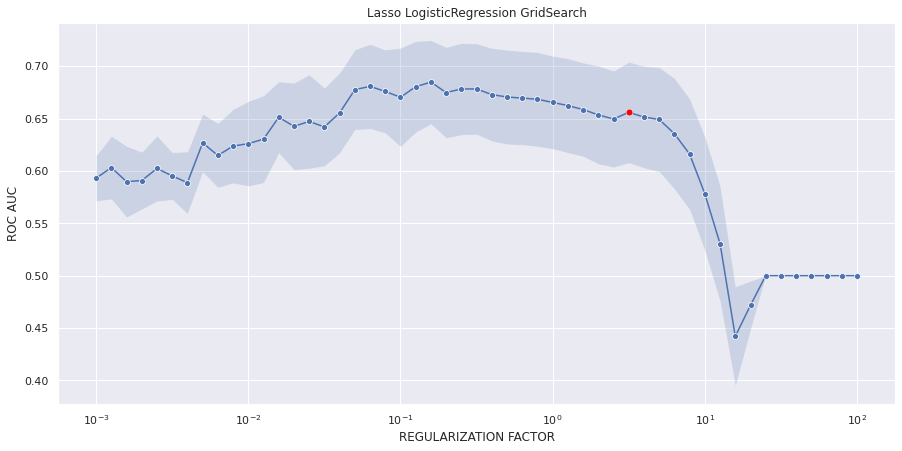

In [63]:
sns.set_theme()
plt.figure(figsize=(15,7))
ax = sns.lineplot(data=scores, x='c', y='score', ci=scores.std, markers=True, marker='o')
ax.fill_between(1/parameters['C'], y1=lasso_gs.cv_results_['mean_test_score'] - lasso_gs.cv_results_['std_test_score']/2, 
                y2=lasso_gs.cv_results_['mean_test_score'] + lasso_gs.cv_results_['std_test_score']/2, alpha=.2)
ax.set_xscale('log')
ax.set_ylabel('ROC AUC')
ax.set_xlabel('REGULARIZATION FACTOR')
ax.set_title('Lasso LogisticRegression GridSearch')
plt.plot(s['c'][15],s['score'][15], 'ok', markersize=5, color='red')
#ax.set_ylim([0.475,0.7])

In [64]:
lasso_gs.best_estimator_

LogisticRegression(C=6.309573444801936, penalty='l1', random_state=1234,
                   solver='liblinear', verbose=3)

In [65]:
c[15]

0.31622776601683794

In [66]:
method_name = 'Lasso'

#lasso = lasso_gs.best_estimator_
lasso = LogisticRegression(C=c[15], penalty='l1', random_state=1234, solver='liblinear', verbose=1)

xval_score = cross_val_score(lasso,X_train,y_train,cv=crossvalidation)

# compute the basic statistics
accuracy_mean = np.average(xval_score)
accuracy_std = np.std(xval_score)

lasso.fit(X_train,y_train)
yp = lasso.predict(X_test)

importances = lasso.coef_

prec = np.average(cross_val_score(lasso,X_train,y_train,cv=crossvalidation, scoring='precision'))
    
rec = np.average(cross_val_score(lasso,X_train,y_train,cv=crossvalidation, scoring='recall'))
    
f1_metric = np.average(cross_val_score(lasso,X_train,y_train,cv=crossvalidation, scoring='f1'))
    
auc_metric = np.average(cross_val_score(lasso,X_train,y_train,cv=crossvalidation, scoring='roc_auc'))


print('\n')    
print("%40s"%method_name)
print("========================================")
print("\t  Accuracy (CV) %.3f %.3f"%(np.average(xval_score),np.std(xval_score)))
print("\tAccuracy (Test) %.3f"%accuracy_score(y_test, yp))
print("\t      Precision %.3f"%prec)
print("\t      Recall    %.3f"%rec)
print("\t      F1        %.3f"%f1_metric)
print("\t      AUC (CV)  %.3f"%auc_metric)
print("\t      AUC (Test)%.3f"%roc_auc_score(y_test, yp))
print("\n")

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

                                   Lasso
	  Accuracy (CV) 0.586 0.089
	Accuracy (Test) 0.538
	      Precision 0.559
	      Recall    0.507
	      F1        0.527
	      AUC (CV)  0.656
	      AUC (Test)0.512




In [67]:
importances = lasso.coef_.flatten()
importances.shape[0]

14527

In [68]:
indices = np.argsort(np.absolute(importances))[::-1]#[0:100]
indices = indices[np.absolute(importances[indices])>0.000001]

In [69]:
selected_features = importances[indices]

In [70]:
len(selected_features)

189

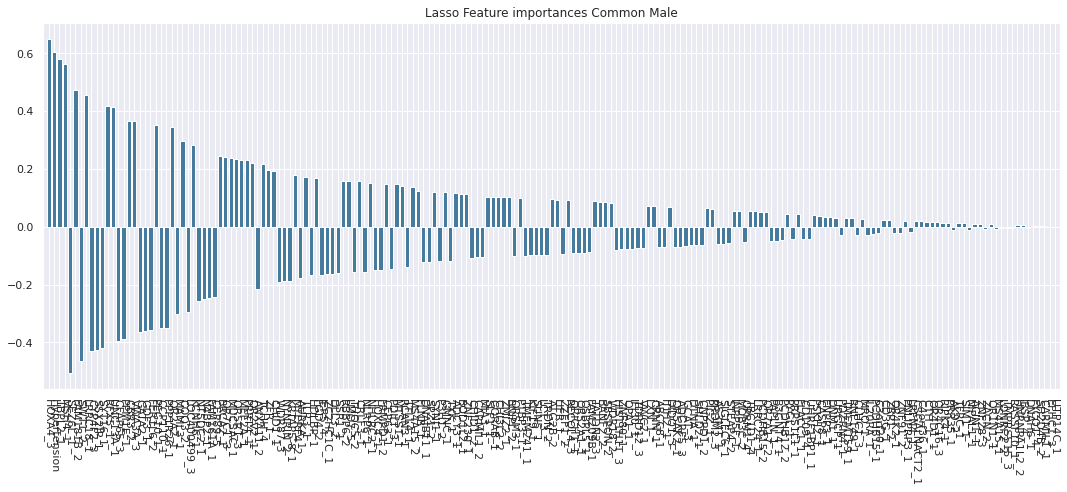

In [71]:
n_features = len(selected_features)

fig, ax = plt.subplots(figsize=(15,7))

plt.title("Lasso Feature importances Common Male")

ax.bar(range(n_features), importances[indices],
        color="#457b9d", yerr=None, align="center")

plt.xticks(range(n_features), X.columns[indices],rotation='-90')
#ax.get_xticklabels()[1].set_fontweight("bold")
#ax.get_xticklabels()[4].set_fontweight("bold")
#ax.get_xticklabels()[16].set_fontweight("bold")

plt.xlim([-1, len(selected_features)])#X.shape[1]])
plt.tight_layout()
#plt.savefig('./Plots/Feature_importances_adjbyage.png',dpi=150)
plt.show()

In [72]:
X.columns[indices].tolist()

['HOXA4_3',
 'Hypertension',
 'TBPL2_1',
 'MSH4_1',
 'SEZ6L_1',
 'FAM181B_2',
 'SWT1_2',
 'LRRC18_1',
 'CYP4F2_3',
 'SSX2IP_1',
 'SYT16_1',
 'RFX5_1',
 'UNC13A_1',
 'CFAP65_3',
 'PPM1E_1',
 'CBR3_2',
 'VWA3A_3',
 'GATA2_1',
 'GDF3_1',
 'FER1L6_2',
 'PEG10_1',
 'CCP110_1',
 'PPP1R26_1',
 'OR2A2_1',
 'MAML3_1',
 'COQ3_2',
 'LOC400499_3',
 'KCNH6_1',
 'NT5DC2_1',
 'N4BP2_1',
 'FAM161A_1',
 'CEP89_5',
 'BRCA2_1',
 'OR7C1_3',
 'MUC5AC_1',
 'OR5R1_3',
 'MEF2A_1',
 'PRRT4_1',
 'OR2V2_1',
 'ANXA11_2',
 'TCHH_4',
 'ZFR_1',
 'CHID1_1',
 'WDR87_3',
 'NYNRIN_2',
 'KRTAP5-8_1',
 'MTERF4_2',
 'AURKA_1',
 'TLR3_1',
 'HDLBP_1',
 'FGD4_2',
 'IER5_4',
 'ZC2HC1C_1',
 'DLL3_2',
 'SSR1_1',
 'RBBP6_2',
 'LMO7_5',
 'THOC5_2',
 'CRLF3_1',
 'NLRP6_1',
 'NHLRC2_1',
 'HOXC4_1',
 'FRMPD1_2',
 'CEP63_1',
 'PDILT_3',
 'MTSS1_1',
 'RCAN3_1',
 'TTLL4_1',
 'MS4A15_2',
 'FLNB_1',
 'DNAJB11_1',
 'SPZ1_2',
 'SYNJ1_1',
 'P3H1_2',
 'GMNC_1',
 'TXK_1',
 'ADCY3_1',
 'BOD1L2_1',
 'ZNF230_1',
 'CHID1_2',
 'CARMIL1_2',
 'MIA3_1

In [73]:
X.columns[indices][X.columns[indices]=='SWT1_2']

Index(['SWT1_2'], dtype='object')

In [74]:
piero = ['GMNC_1','PPARGC1A_2','OSBPL5_1','FAM118A_1','OR7A17_2','LRRFIP1_1','FAM181B_2','TLR3_1','SPNS3_1','PCDHB15_2',
'LRRC43_1','LY6D_1','ITIH2_1','ZNF75A_1','HOXA4_1','HSDL1_1','CEP63_1','ULBP3_1','PSKH2_1','LINS1_3','HNRNPA1L2_2',
'ZZEF1_2','TRIM65_2','PNPT1_1','HOXD4_1','PDILT_3','AS3MT_1','C4orf36_1','ANO9_1','ANXA11_2','PLELHN1_1','FBXW4_1',
'RBBP6_2','AP3D1_1','LRP2_2','CBR3_2','VWA3A_3','SEC16A_1','CEP89_5','PDHX_1']

In [75]:
np.setdiff1d(piero,X.columns[indices])

array(['ANO9_1', 'AP3D1_1', 'FAM118A_1', 'FBXW4_1', 'HOXA4_1', 'HOXD4_1',
       'HSDL1_1', 'LINS1_3', 'LRP2_2', 'LRRC43_1', 'LRRFIP1_1', 'LY6D_1',
       'PDHX_1', 'PLELHN1_1', 'PNPT1_1', 'PPARGC1A_2', 'SEC16A_1',
       'SPNS3_1', 'TRIM65_2', 'ULBP3_1', 'ZNF75A_1'], dtype='<U11')

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

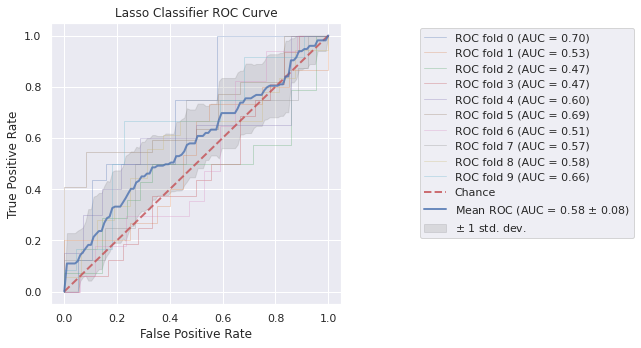

In [81]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(10,5))
for i, (train, test) in enumerate(crossvalidation.split(X_train, y_train)):
    lasso.fit(X.iloc[train], y.iloc[train])
    viz = plot_roc_curve(lasso, X.iloc[test], y.iloc[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Lasso Classifier ROC Curve")
ax.legend(bbox_to_anchor=(1.25, 1.0))
plt.tight_layout()
#plt.savefig('./Plots/Lasso Adjusted by age ROC.png',dpi=150)
plt.show()

In [77]:
yp_cv = cross_val_predict(lasso, X, y, cv=crossvalidation)
tn, fp, fn, tp = confusion_matrix(y, yp_cv).ravel()

#tn, fp, fn, tp = confusion_matrix(y_test, yp).ravel()

conf = [[tn,fn],[fp,tp]]

confusion = np.array(conf)

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

Text(0.5, 1.0, 'Lasso Confusion Matrix')

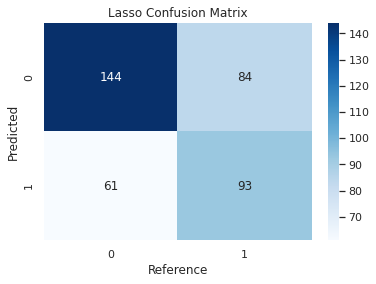

In [78]:
ax = sns.heatmap(confusion, annot=True, cmap='Blues',fmt='g')
ax.set_ylabel('Predicted')
ax.set_xlabel('Reference')
ax.set_title('Lasso Confusion Matrix')
#ax.set_xticklabels(['Absent','Present'])
#ax.set_yticklabels(['Absent','Present'])
#plt.savefig('./Plots/Lasso Confusion matrix adj by age.png', dpi=150)

In [97]:
#selected_features = X.columns[indices]

In [99]:
#df_out = df.loc[:, selected_features]
#df_out['grading'] = df['grading']
#df_out.to_csv('./selected_features_adjusted_by_age.csv',index=False)